# Прогнозирование заказов такси

**Дано:**  
компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах

**Найти:**
модель предсказания количества заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48, обучение - с различными гиперпараметрами и тестовой выборкой размером 10% от исходных данных

**План исследования:**
 1. Обзор данных и ресемплирование по 1 часу 
 2. Анализ данных
 3. Обучение и тестирование моделей 
 4. Вывод

## 1. Обзор данных

In [1]:
import pandas as pd

import numpy as np 

import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

from lightgbm import LGBMRegressor

from itertools import product

/Users/galina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/galina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
try:
    taxi = pd.read_csv('/Users/galina/Desktop/учёба/спринт 12. Временные ряды/taxi.csv', index_col=[0], parse_dates=[0]) 
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(taxi.head(6))
print('-----------------------------------------------------------------')

display(taxi.tail(6))
print('-----------------------------------------------------------------')

display(taxi.info())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(taxi.isna().sum())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


-----------------------------------------------------------------


,num_orders
datetime,
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

-----------------------------------------------------------------
Кол-во пропусков:


num_orders    0
dtype: int64

In [4]:
#ресемплирую данные по одному часу:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

 ### Вывод по п.1. Обзор данных:
 1. Данные с 1 марта 2018 по 31 августа 2018, всего 26 496 записей, достаточно для анализа
 2. Пропусков нет, тип данных в столбце num_orders менять не надо
 3. Дубликаты искать бессмысленно, так как кол-во заказов из-за сезонности и времени суток может повторяться
 4. Данные ресемплированы по 1 часу по условию задачи

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Ресемплирование выполнено верно 👍 Суммирование проще интерпретируется, чем использование других агрегационных функций
</div>

## 2. Анализ данных

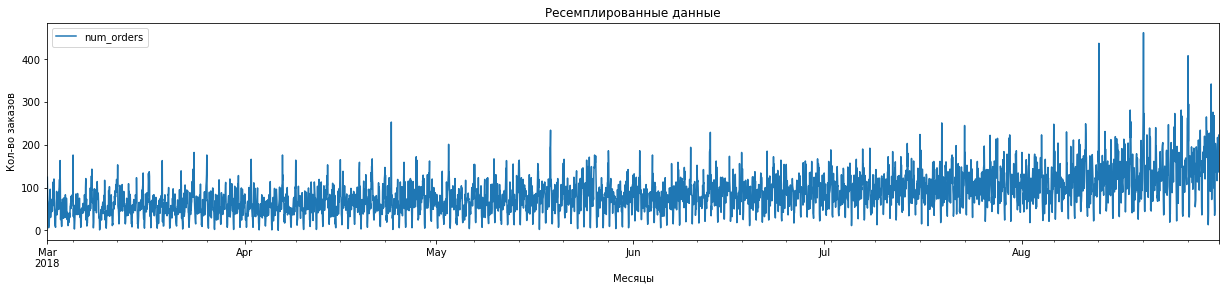

In [5]:
#вывожу график ресемплированных данных:
figsize = (21,4)
taxi.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

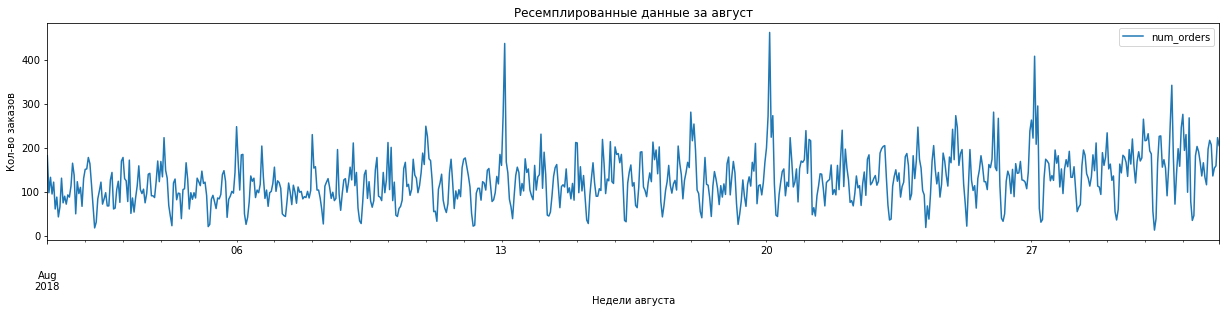

In [6]:
#вывожу график за август:
taxi_aug = taxi['2018-08-01':]
taxi_aug.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

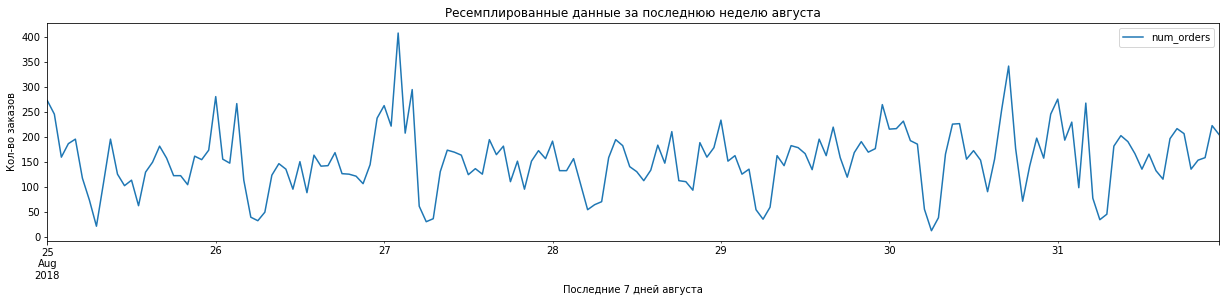

In [7]:
#вывожу график за последнюю неделю августа:
taxi_aug_7days = taxi['2018-08-25':]
taxi_aug_7days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

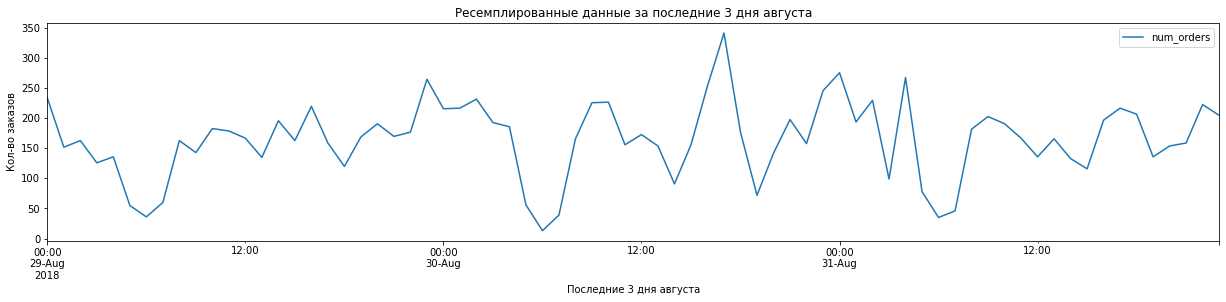

In [8]:
#вывожу график за последние 3 дня августа:
taxi_aug_3days = taxi['2018-08-29':]
taxi_aug_3days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Промежуточный вывод:
1. На графике ресемплированных по 1 часу данных видно, что кол-во заказов начинает возрастать, при этом в августе всплески заказов по понедельникам
2. Видно падение заказов по утрам и затем подъем к 12:00

### 2.1. Скользящее среднее

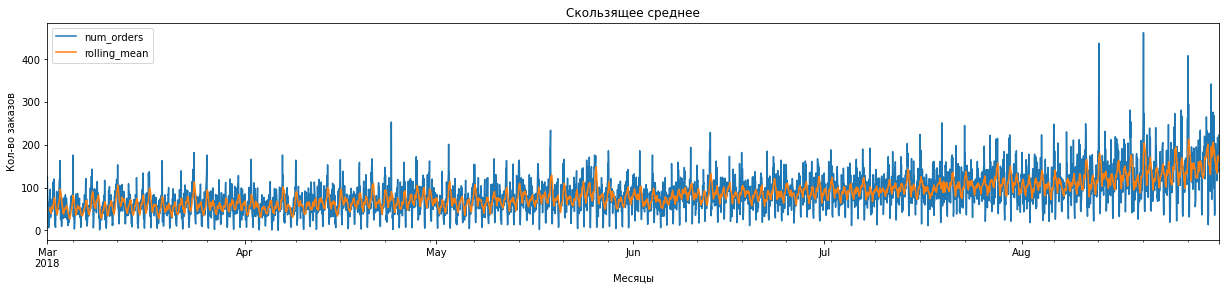

In [9]:
taxi['rolling_mean'] = taxi.rolling(10).mean()
taxi.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Визуализировали исходный и сглаженный временной ряд - отлично!
</div>

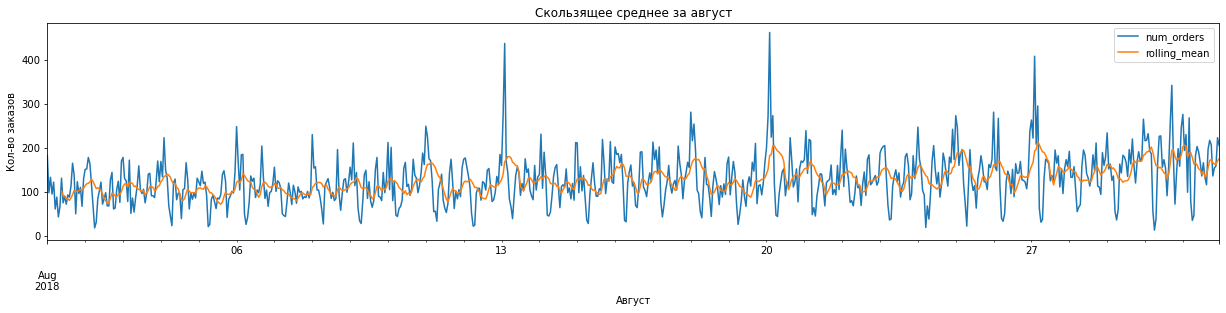

In [10]:
taxi_aug['rolling_mean'] = taxi_aug.rolling(10).mean()
taxi_aug.plot(figsize=figsize)
plt.title('Скользящее среднее за август')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

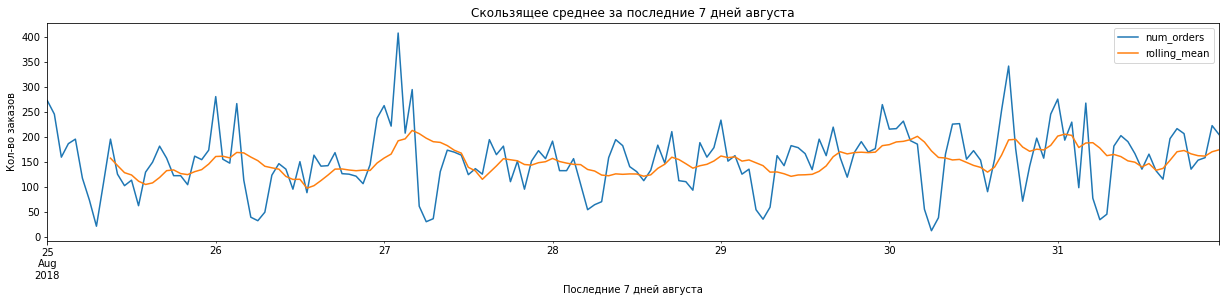

In [11]:
taxi_aug_7days['rolling_mean'] = taxi_aug_7days.rolling(10).mean()
taxi_aug_7days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 7 дней августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

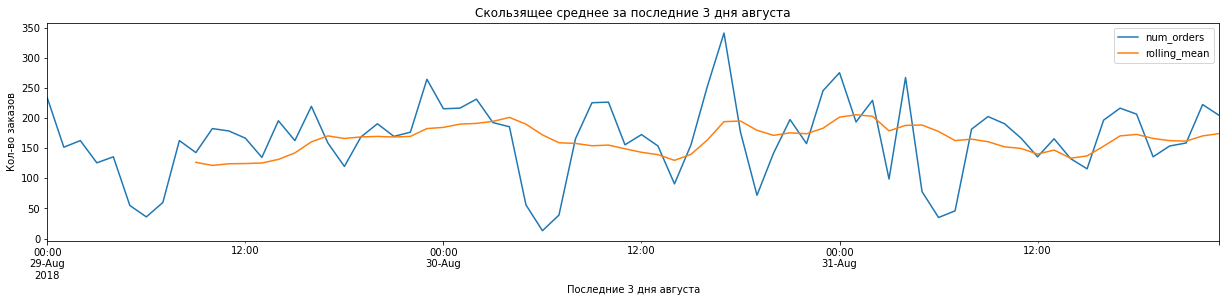

In [12]:
taxi_aug_3days['rolling_mean'] = taxi_aug_3days.rolling(10).mean()
taxi_aug_3days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

### 2.2. Тест Дики-Фуллера
(нашла тут https://russianblogs.com/article/4449640394/)

In [13]:
test = sm.tsa.adfuller(taxi.num_orders)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027951
p-value:  0.028940051402613316
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Промежуточный вывод: значение t-статистики -3,06 больше значений на 5% и 10% доверительных интервалах, то есть гипотеза, что ряд стационарный, не может быть отвергнута

### 2.3. Тест Харке-Бера

In [14]:
row =  [u'statistic', u'p-value', u'skewness', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(taxi.num_orders)
a = np.vstack([jb_test])
print(SimpleTable(a, row))

    statistic      p-value      skewness           kurtosis    
---------------------------------------------------------------
3644.4335517264863     0.0 1.1885516779344458 6.762457138757449
---------------------------------------------------------------


Промежуточный вывод: поскольку p-value - 0.0, то гипотеза о нормальности распределения отвергается, то есть ряд скорее всего стационарным не является (да?). Кроме того, skewness (асимметрия) не равна нулю, kurtosis (эксцесс) - не равен 3, то есть гипотеза о нормальности распределения отвергается

### 2.4. Декомпозиция

In [15]:
#декомпозирую данные:
decomposed = seasonal_decompose(taxi.num_orders)
decomposed_aug = seasonal_decompose(taxi_aug.num_orders)
decomposed_aug_3days = seasonal_decompose(taxi_aug_3days.num_orders)

#### Тренды за весь период, за последний месяц и последние 3 дня

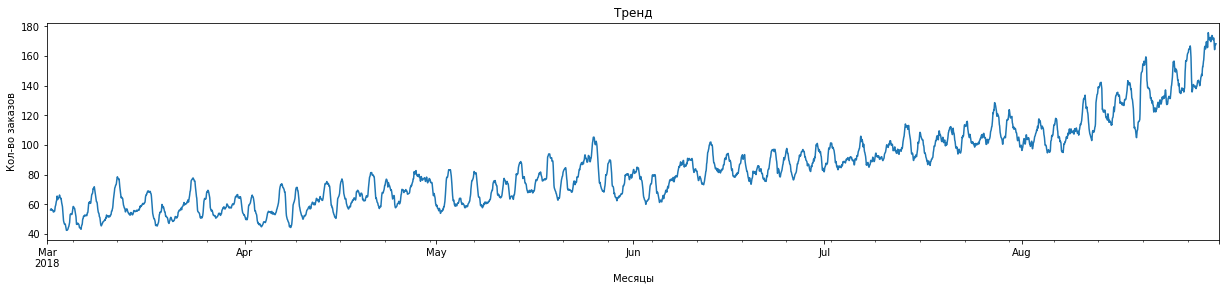

In [16]:
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

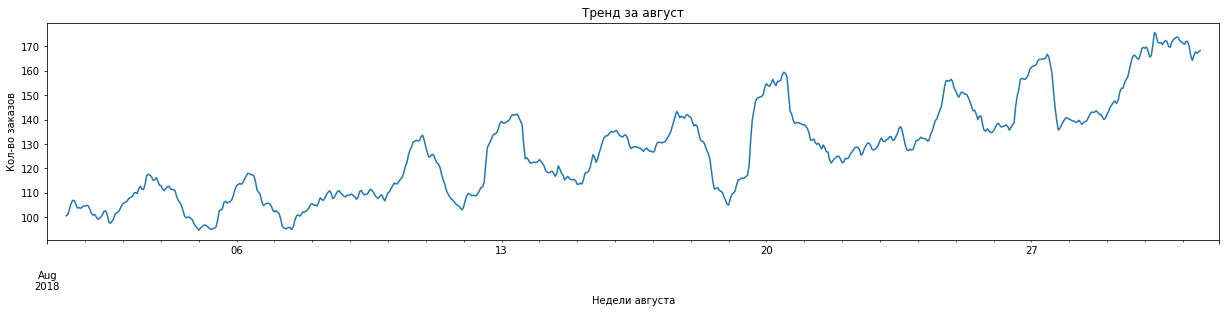

In [17]:
decomposed_aug.trend.plot(figsize=figsize)
plt.title('Тренд за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

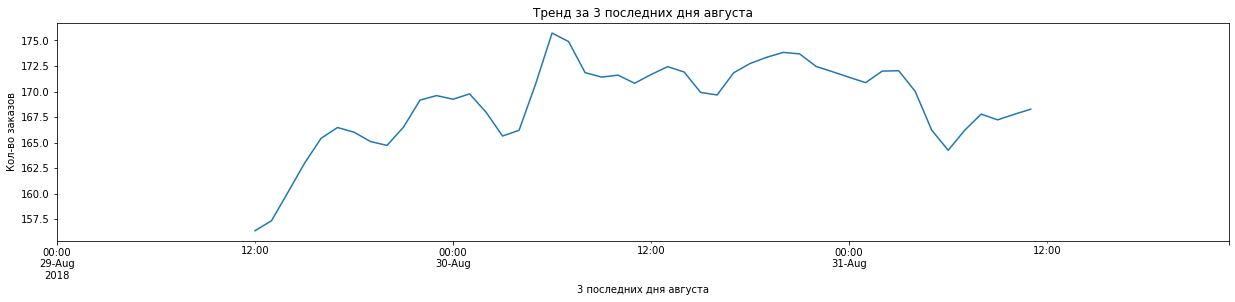

In [18]:
decomposed_aug_3days.trend.plot(figsize=figsize)
plt.title('Тренд за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

#### Сезонность за весь период, за последний месяц и за последние 3 дня

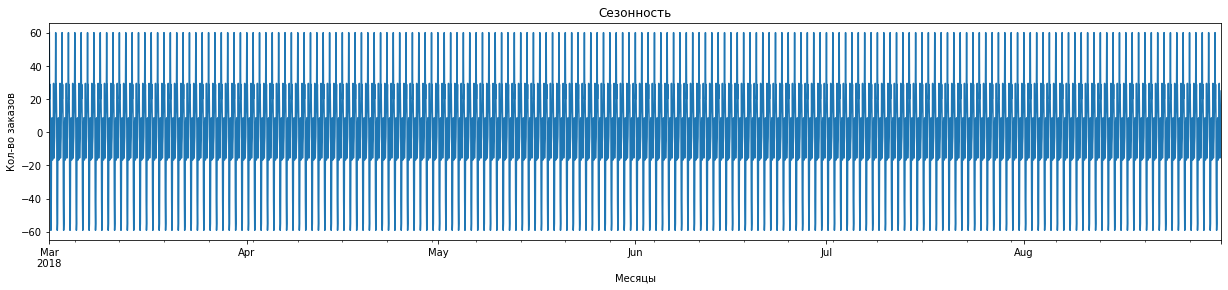

In [19]:
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

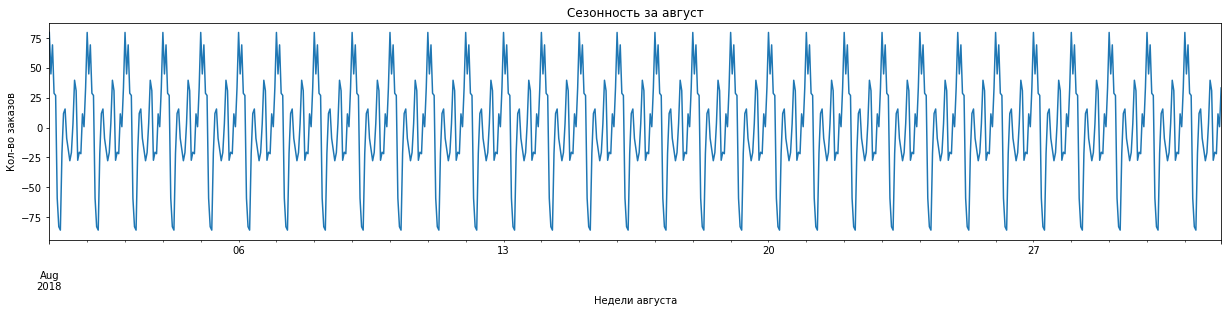

In [20]:
decomposed_aug.seasonal.plot(figsize=figsize)
plt.title('Сезонность за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

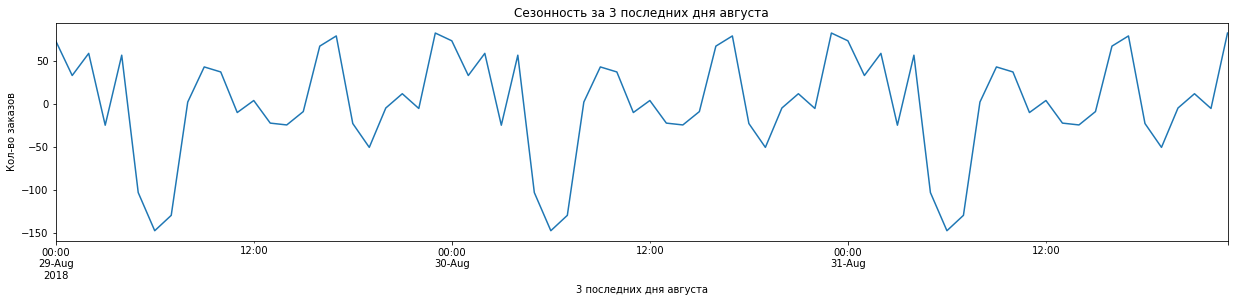

In [21]:
decomposed_aug_3days.seasonal.plot(figsize=figsize)
plt.title('Сезонность за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Промежуточный вывод: сезонность явно сутки, так как на графике за 3 дня видно, что на всех 3 днях:
- падение заказов и минимум в районе 06:00 и 18:00
- рост заказов и максимум в районе 09:00 и 00:00

#### Остатки за весь период, за последний месяц и за посление 3 дня

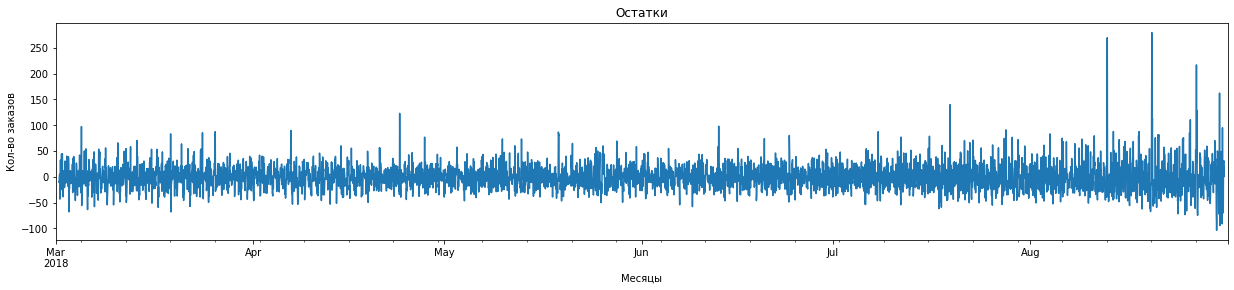

In [22]:
decomposed.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

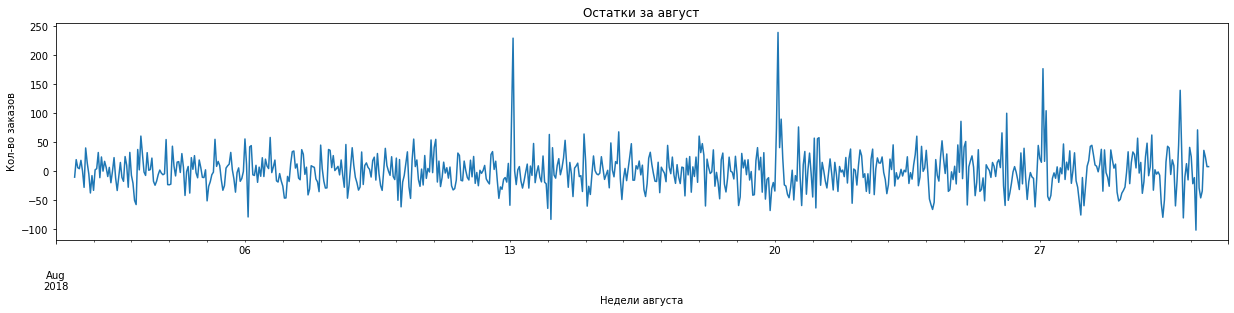

In [23]:
decomposed_aug.resid.plot(figsize=figsize)
plt.title('Остатки за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

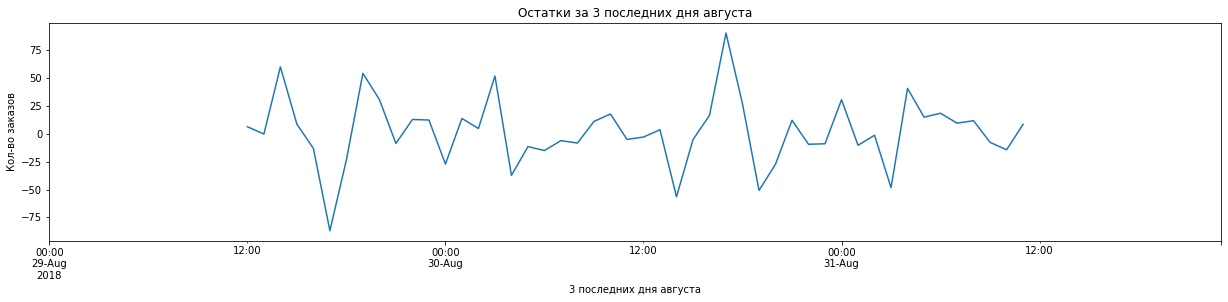

In [24]:
decomposed_aug_3days.resid.plot(figsize=figsize)
plt.title('Остатки за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Вывод по п.2. Анализ данных:
1. Тест Дики-Фуллера показал, что ряд (без разбивки на тренд, сезонность) можно считать стационарным, однако явно есть сезонность и восходящий тренд, поэтому результаты теста Дики-Фулера можно не принимать во внимание. Кроме того, по результату теста Харке-Бера гипотеза о нормальности распределения отвергается.
2. Тренд идет на явное возрастание, то есть он не стационарный - это видно и на графике тренда, и на графике ресемплированных по 1 часу данных. Даже если убрать тренд и сезонность, то на графике остатков все равно видны всплески
3. Есть явная суточная сезонность - больше всего заказов 09:00 и 00:00, меньше всего в районе 06:00 и 18:00. С учетом того, что это заказы в аэропорты, люди выбирают либо утренние, либо ночные рейсы 
4. Дни по кол-ву заказов отличаются друг от друга, то есть надо будет учесть день
5. По понедельникам есть увеличение заказов, то есть надо будет учесть день недели

## 3. Обучение и тестирование моделей

In [25]:
#ввожу функцию признаков:
def make_features(data, max_lag, rolling_mean_size):
    data = taxi.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

### 3.1. Линейная регрессия

In [26]:
#обучаю и проверяю модель со сменой параметров:
best_rmse = 48

for max_lag in range(1, 100):
    for rolling_mean_size in range(1, 100):
        data = make_features(taxi, max_lag, rolling_mean_size)

        train, valid = train_test_split(data, shuffle=False, test_size=.55)
        train = train.dropna()

        valid, test = train_test_split(valid, shuffle=False, test_size=.182)

        features_train = train.drop('num_orders', axis=1)
        target_train = train.num_orders

        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid.num_orders

        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        rmse = mean_squared_error(target_valid, predictions) ** .5
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            
print('лучшее RMSE =', best_rmse, 'при лаге', best_max_lag, ', окне', best_rolling_mean_size)

лучшее RMSE = 25.99656437256906 при лаге 97 , окне 20


In [27]:
#тестирую модель на лучших параметрах:
data = make_features(taxi, best_max_lag, best_rolling_mean_size)

train, valid = train_test_split(data, shuffle=False, test_size=.55)
train = train.dropna()

valid, test = train_test_split(valid, shuffle=False, test_size=.182)

features_train = train.drop('num_orders', axis=1)
target_train = train.num_orders

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid.num_orders

features_test = test.drop('num_orders', axis=1)
target_test = test.num_orders

model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
        
rmse = mean_squared_error(target_test, predictions) ** .5
print('RMSE линейной регресии на тестовой выборке =',rmse)

RMSE линейной регресии на тестовой выборке = 43.55811661293622


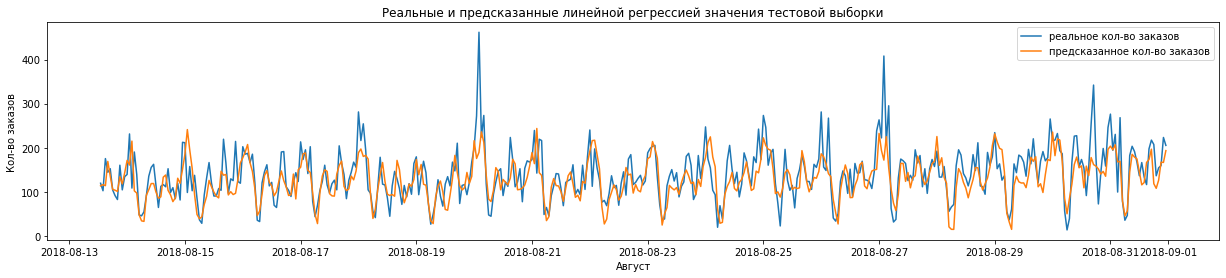

In [28]:
#визуализирую реальные и предсказанные значения тестовой выборки:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

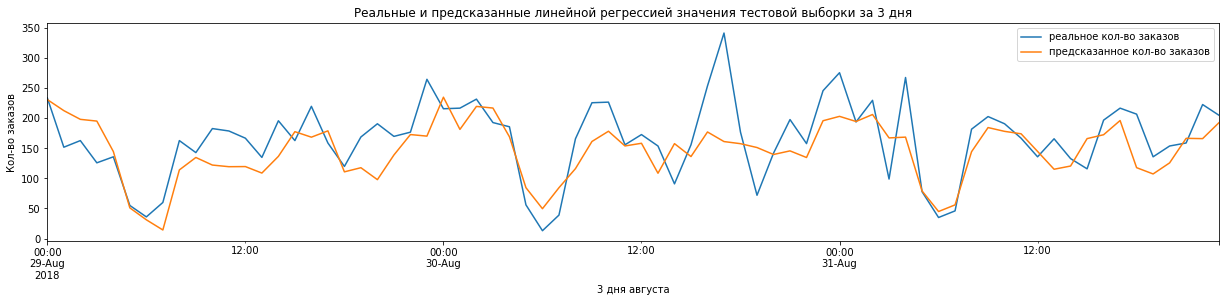

In [29]:
#визуализирую реальные и предсказанные значения тестовой выборки за 3 дня:
data = pd.DataFrame(data={'реальное кол-во заказов': target_test['2018-08-29':],
                          'предсказанное кол-во заказов': predictions[371:]})  
                        #не знаю, как иначе сделать выбор 3 дней
    
data.plot(figsize=figsize)
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки за 3 дня')
plt.xlabel('3 дня августа')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Промежуточный вывод: на графике видно, что линейная регрессия достаточно точно предсказывает значения, за исключением всплесков на остатках

### 3.2. Дерево решений

In [30]:
best_rmse = 48

for max_lag in range(1, 15):                  #сократила, иначе очень долго считает
    for rolling_mean_size in range(1, 35):
        for max_depth in range(2, 21):
            data = make_features(taxi, max_lag, rolling_mean_size)

            train, valid = train_test_split(data, shuffle=False, test_size=.55)
            train = train.dropna()

            valid, test = train_test_split(valid, shuffle=False, test_size=.182)

            features_train = train.drop('num_orders', axis=1)
            target_train = train.num_orders

            features_valid = valid.drop('num_orders', axis=1)
            target_valid = valid.num_orders

    
            model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
        
            rmse = mean_squared_error(target_valid, predictions) ** .5
        
            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_max_depth = max_depth
            
print('лучшее RMSE =', best_rmse)
print('при лаге', best_max_lag)
print('окне', best_rolling_mean_size)
print('глубине', best_max_depth)

лучшее RMSE = 34.010912056307994
при лаге 2
окне 8
глубине 7


In [31]:
#тестирую модель на лучших параметрах:
data = make_features(taxi, best_max_lag, best_rolling_mean_size)

train, valid = train_test_split(data, shuffle=False, test_size=.55)
train = train.dropna()

valid, test = train_test_split(valid, shuffle=False, test_size=.182)

features_train = train.drop('num_orders', axis=1)
target_train = train.num_orders

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid.num_orders

features_test = test.drop('num_orders', axis=1)
target_test = test.num_orders

model = DecisionTreeRegressor(max_depth=best_max_depth, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
        
rmse = mean_squared_error(target_test, predictions) ** .5
print('RMSE дерева решений на тестовой выборке =',rmse)

RMSE дерева решений на тестовой выборке = 72.94889189270961


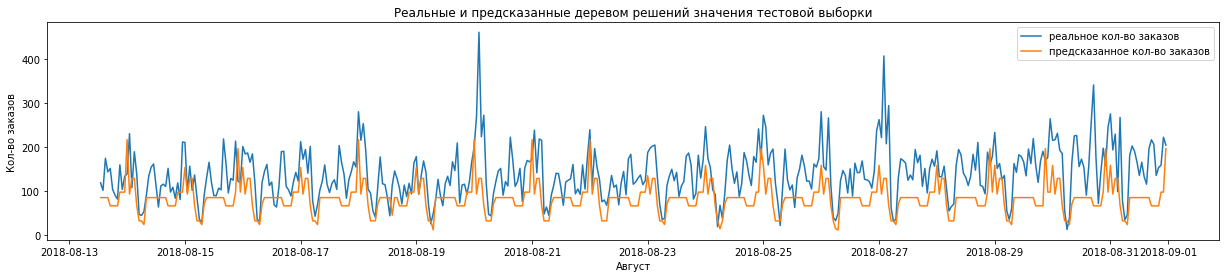

In [32]:
#визуализирую реальные и предсказанные значения тестовой выборки:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные деревом решений значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Промежуточный вывод: и RMSE, и графики показывают, что дерево решений неточно предсказывает

### 3.3. LightGBMRegressor

In [33]:
model = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)  #использую выборки, выведенные выше

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme = (max(mts) * -1) ** .5
print('RMSE LightGBMRegressor на тренировочной выборке =',rmse)

{'learning_rate': 0.1, 'num_leaves': 25, 'random_state': 12345}

RMSE LightGBMRegressor на тренировочной выборке = 72.94889189270961


In [34]:
model = LGBMRegressor(learning_rate=.1, num_leaves=25, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rsme = mean_squared_error(target_test, predictions) ** .5
print('RMSE LightGBMRegressor на тестовой выборке =', rsme)

RMSE LightGBMRegressor на тестовой выборке = 64.68977169724347


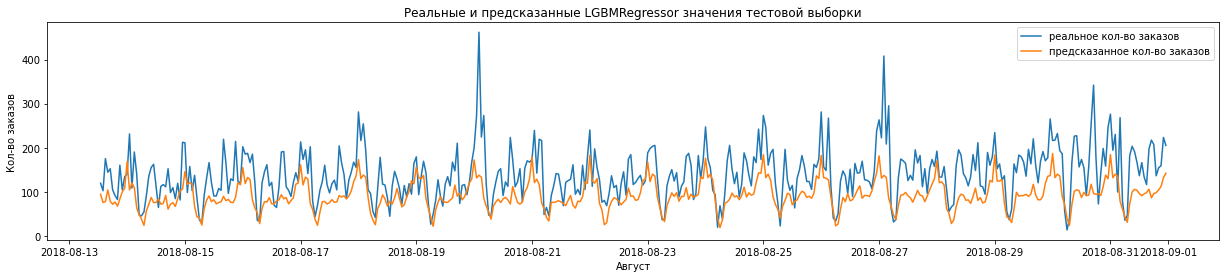

In [35]:
#визуализирую реальные и предсказанные значения тестовой выборки:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные LGBMRegressor значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Промежуточный вывод: и RMSE, и графики показывают, что  LightGBMRegressor неточно предсказывает

### Выводы по п.3. Обучение и тестирование моделей:
1. Обучила 3 модели - линейную регрессию, дерево решений и LGBMRegressor - со сменой параметров.
2. Наилучший результат дала линейная регрессия - на тестовой выборке RMSE = 44

## 4. Вывод

В проекте:
- загрузила  данные 
- провела их анализ
- сравнила 3 модели с разными гиперпараметрами, проверила их на тестовых выборках
- выбрала лучшую модель по RMSE

Итог - наилучшей моделью стала линейная регрессия, которая на валидационной и тестовой выборке показала RMSE < 48